In [1]:
# Download the dataset (we will need only Java Funcom subset)

# gdown 1m4uZi0hoInYxkgrSlF23EjVasSgaXOXy
# unzip FSE_dataset.zip

In [1]:
from datasets import load_dataset, DatasetDict


data_dir = '../dataset/clean/docstring/'
data_files = {
    'train': data_dir + 'train/docstring.train',
    'test': data_dir + 'test/docstring.test',
    'valid': data_dir + 'valid/docstring.valid'
}

funcom = DatasetDict({
    'train': load_dataset('json', data_files=data_files['train'], split='train'),
    'test': load_dataset('json', data_files=data_files['test'], split='train'),
    'valid': load_dataset('json', data_files=data_files['valid'], split='train')
})
funcom

Found cached dataset json (/root/.cache/huggingface/datasets/json/default-f112521508a2c83f/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/root/.cache/huggingface/datasets/json/default-c98ca934df233e6d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/root/.cache/huggingface/datasets/json/default-810e345add771a51/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


DatasetDict({
    train: Dataset({
        features: ['id', 'raw_code', 'raw_comment', 'code', 'comment'],
        num_rows: 1184438
    })
    test: Dataset({
        features: ['id', 'raw_code', 'raw_comment', 'code', 'comment'],
        num_rows: 69392
    })
    valid: Dataset({
        features: ['id', 'raw_code', 'raw_comment', 'code', 'comment'],
        num_rows: 62702
    })
})

In [2]:
funcom['train'][4]

{'id': '43227138',
 'raw_code': '  public Statement createStatement() throws SQLException {\n    // TODO Auto-generated method stub\n    return connection.createStatement();\n  }\n',
 'raw_comment': '  /**\n   * Creates a new, empty <code>Statement</code> object.\n   *   \n   * @return              The <code>Statement</code> object\n   * @throws SQLException if a database access error occurs\n   */\n',
 'code': 'public statement create statement throws sqlexception return connection create statement',
 'comment': 'creates a new empty statement object'}

In [78]:
from tqdm import tqdm


code_lengths = {}
code_tokens_lengths = {}
comment_lengths = {}
for t in ['train', 'test', 'valid']:
    code_lengths[t] = []
    code_tokens_lengths[t] = []
    comment_lengths[t] = []
    for el in tqdm(funcom[t]):
        code_lengths[t].append(len(el['code'].split()))
        code_tokens_lengths[t].append(len(el['code_tokens']))
        comment_lengths[t].append(len(el['comment'].split()))

100%|██████████| 62702/62702 [00:16<00:00, 3741.35it/s]


In [79]:
import numpy as np


for t in ['train', 'test', 'valid']:
    code_lengths[t] = np.array(code_lengths[t])
    code_tokens_lengths[t] = np.array(code_tokens_lengths[t])
    comment_lengths[t] = np.array(comment_lengths[t])

for t in ['train', 'test', 'valid']:
    print(t)
    print(np.min(code_lengths[t]), np.mean(code_lengths[t]), np.max(code_lengths[t]))
    print(np.min(code_tokens_lengths[t]), np.mean(code_tokens_lengths[t]), np.max(code_tokens_lengths[t]))
    print(np.min(comment_lengths[t]), np.mean(comment_lengths[t]), np.max(comment_lengths[t]))
    print()

train
2 33.42471366166908 100
16 258.74747686244444 1201
1 8.566740513222305 111

test
3 34.49420682499424 100
28 265.8989220659442 1124
1 8.341408231496427 69

valid
3 33.933989346432334 100
28 262.92698797486526 1124
1 8.426637108864151 60



<Axes: >

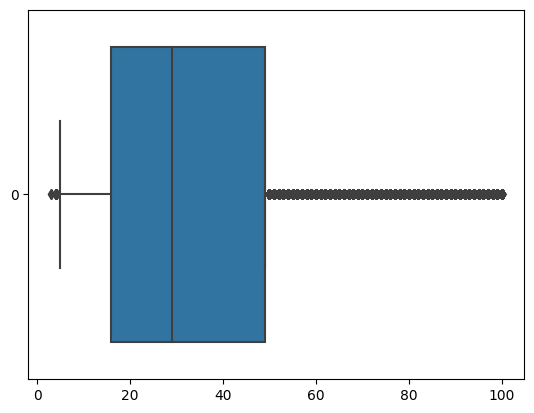

In [80]:
import seaborn as sns
import pandas as pd


sns.boxplot(data=pd.DataFrame(data=code_lengths['test']), whis=[0.05, 0.99], orient='horizontal')

<Axes: >

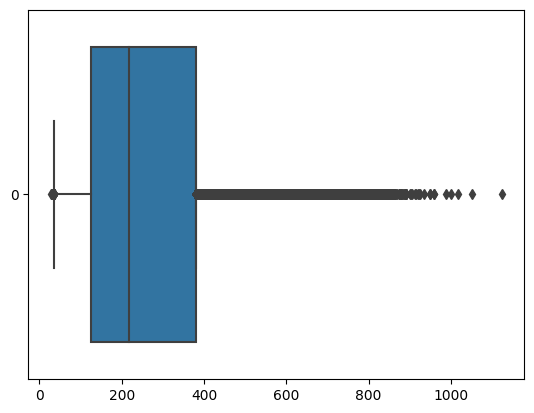

In [81]:
sns.boxplot(data=pd.DataFrame(data=code_tokens_lengths['test']), whis=[0.05, 0.99], orient='horizontal')

<Axes: >

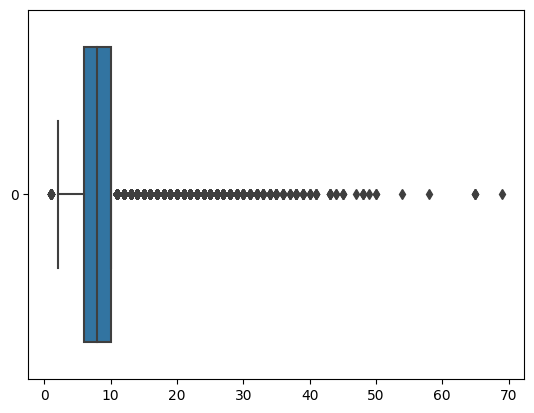

In [82]:
sns.boxplot(data=pd.DataFrame(data=comment_lengths['test']), whis=[0.05, 0.99], orient='horizontal')

In [96]:
df = pd.DataFrame(data=comment_lengths['test'])
df[df[0] > np.percentile(df, 99)].sort_values(0)  # values above 99% of the whole data

,0
39290,24
39291,24
49899,24
51526,24
65224,24
...,...
48573,58
12718,65
12712,65
12774,65


In [33]:
from pathlib import Path


save_dir = 'CodeBERT/UniXcoder/downstream-tasks/code-summarization/dataset/python'
Path(save_dir).mkdir(parents=True, exist_ok=True)

In [35]:
import json
from tqdm import tqdm


# Load the Hugging Face dataset
dataset = funcom

# Split the dataset into train, valid, and test sets
train_dataset = dataset['train']
valid_dataset = dataset['valid']
test_dataset = dataset['test']

# Function to create a jsonl file given a dataset
def create_jsonl_file(dataset, filename):
    with open(filename, 'w') as f:
        for example in tqdm(dataset):
            code_tokens = example['code_tokens']
            docstring_tokens = example['docstring_tokens']
            json_line = json.dumps({'code_tokens': code_tokens, 'docstring_tokens': docstring_tokens})
            f.write(json_line + '\n')

# Create jsonl files for train, valid, and test datasets
create_jsonl_file(train_dataset, f'{save_dir}/train.jsonl')
create_jsonl_file(valid_dataset, f'{save_dir}/valid.jsonl')
create_jsonl_file(test_dataset, f'{save_dir}/test.jsonl')

100%|██████████| 69392/69392 [00:21<00:00, 3183.34it/s]


In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
# Fine-tuning
!cd ./CodeBERT/UniXcoder/downstream-tasks/code-summarization; python3 run.py \
	--do_train \
	--do_eval \
	--model_name_or_path microsoft/unixcoder-base \
	--train_filename dataset/java/train.jsonl \
	--dev_filename dataset/java/valid.jsonl \
	--output_dir saved_models/java \
	--max_source_length 256 \
	--max_target_length 128 \
	--beam_size 10 \
	--train_batch_size 48 \
	--eval_batch_size 48 \
	--learning_rate 5e-5 \
	--gradient_accumulation_steps 2 \
	--num_train_epochs 10 

07/20/2023 11:59:27 - INFO - __main__ -   device: cuda, n_gpu: 1
07/20/2023 11:59:30 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, beam_size=10, dev_filename='dataset/java/valid.jsonl', device=device(type='cuda'), do_eval=True, do_test=False, do_train=True, eval_batch_size=48, gradient_accumulation_steps=2, learning_rate=5e-05, max_grad_norm=1.0, max_source_length=256, max_target_length=128, model_name_or_path='microsoft/unixcoder-base', n_gpu=1, no_cuda=False, num_train_epochs=10, output_dir='saved_models/java', seed=42, test_filename=None, train_batch_size=48, train_filename='dataset/java/train.jsonl', weight_decay=0.0)
07/20/2023 11:59:49 - INFO - __main__ -   *** Example ***
07/20/2023 11:59:49 - INFO - __main__ -   idx: 0
07/20/2023 11:59:49 - INFO - __main__ -   source_tokens: ['<s>', '<encoder-decoder>', '</s>', '<mask0>', 'public', '_void', '_mouse', '_Up', '_(', '_final', '_Mouse', '_Event', '_mouse', 'event', '_)', '_{', '_modify', '_Save'

In [1]:
# Evaluating	
!python3 ./CodeBERT/UniXcoder/downstream-tasks/code-summarization/run.py \
	--do_test \
	--model_name_or_path microsoft/unixcoder-base \
	--test_filename ./CodeBERT/UniXcoder/downstream-tasks/code-summarization/dataset/java/test.jsonl \
	--output_dir ./CodeBERT/UniXcoder/downstream-tasks/code-summarization/saved_models/java \
	--max_source_length 256 \
	--max_target_length 128 \
	--beam_size 10 \
	--train_batch_size 48 \
	--eval_batch_size 48 \
	--learning_rate 5e-5 \
	--gradient_accumulation_steps 2 \
	--num_train_epochs 10

07/25/2023 10:41:34 - INFO - __main__ -   device: cuda, n_gpu: 4
07/25/2023 10:41:38 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, beam_size=10, dev_filename=None, device=device(type='cuda'), do_eval=False, do_test=True, do_train=False, eval_batch_size=48, gradient_accumulation_steps=2, learning_rate=5e-05, max_grad_norm=1.0, max_source_length=256, max_target_length=128, model_name_or_path='microsoft/unixcoder-base', n_gpu=4, no_cuda=False, num_train_epochs=10, output_dir='./CodeBERT/UniXcoder/downstream-tasks/code-summarization/saved_models/java', seed=42, test_filename='./CodeBERT/UniXcoder/downstream-tasks/code-summarization/dataset/java/test.jsonl', train_batch_size=48, train_filename=None, weight_decay=0.0)
  0%|                                        | 4/1446 [00:46<4:42:09, 11.74s/it]
Traceback (most recent call last):
  File "./CodeBERT/UniXcoder/downstream-tasks/code-summarization/run.py", line 432, in <module>
    main()
  File "./CodeBERT

In [32]:
import re


def split_puncts(line):
  return ' '.join(re.findall(r"[\w]+|[^\s\w]", line))


out_dir = './CodeBERT/UniXcoder/downstream-tasks/code-summarization/saved_models/python'

gf = open(f"{out_dir}/test.gold", 'r')
pf = open(f"{out_dir}/test.output", 'r')

gold = {}
pred = {}

for row in pf:
    cols = row.strip().split('\t')
    if len(cols) == 1:
        (rid, prediction) = (cols[0], '') 
    else:
        (rid, prediction) = (cols[0], cols[1]) 
    pred[rid] = split_puncts(prediction.strip().lower())

for row in gf:
    (rid, prediction) = row.split('\t') 
    if rid in pred: # Only insert if the id exists for the method
        if rid not in gold:
            gold[rid] = split_puncts(prediction.strip().lower())

In [43]:
predictions = list(pred.values())
references = list(gold.values())

print(f'#\tpred/gold: value\n')
for i, (p, r) in enumerate(zip(predictions, references)):
    print(f'{i}\tpred: {p}')
    print(f'{i}\tgold: {r}')
    print()
    if i == 50:
        break

#	pred/gold: value

0	pred: gets the member options
0	gold: get members by name

1	pred: gets the model conf entries
1	gold: insert the mapped classes into the hibernate cfg xml file

2	pred: initializes the table
2	gold: loads the table with the member fields of the class defined in the editing cell

3	pred: checks if the editing cell has a source
3	gold: checks if there is a source file for this cell

4	pred: gets the model conf entries
4	gold: insert the mapped classes into the hibernate cfg xml file

5	pred: creates the page
5	gold: writes the contents of getlayoutsource to the layout output file

6	pred: draws the targets
6	gold: draw all selectable targets

7	pred: draws the scene
7	gold: render the scene and flush the opengl pipeline

8	pred: finds a display mode
8	gold: direct copy from the lwjgl wiki

9	pred: process the game
9	gold: process game logic here in the main finite state machine

10	pred: inital initializes the audio engine
10	gold: initialises openal

11	pred: load

In [36]:
import evaluate

# bleu = evaluate.load('bleu')
# bleu_res = bleu.compute(predictions=predictions, references=list([r] for r in references))
# print(bleu_res)

rouge = evaluate.load('rouge')
rouge_res = rouge.compute(predictions=predictions, references=references)
print(rouge_res)

meteor = evaluate.load('meteor')
meteor_res = meteor.compute(predictions=predictions, references=references)
print(meteor_res)

{'rouge1': 0.36335810118371814, 'rouge2': 0.17903848205813427, 'rougeL': 0.3484443081766253, 'rougeLsum': 0.3484442912323825}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'meteor': 0.296884010095024}


# CodeT5

## FT

In [2]:
# Use only once to have a dataset prepared for fine-tuning
funcom.save_to_disk('CodeT5/CodeT5+/cache_data/docstring')

Saving the dataset (0/2 shards):   0%|          | 0/1184438 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/69392 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/62702 [00:00<?, ? examples/s]

In [4]:
%cd ./CodeT5/CodeT5+

/home/user/vladimir/fine-tuning/CodeT5/CodeT5+


In [5]:
import os


os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [ ]:
!python3 tune_codet5p_seq2seq.py \
    --load Salesforce/codet5p-770m-py \
    --save-dir saved_models/funcom-770m-py \
    --fp16 \
    --batch-size-per-replica 16

## Eval

In [7]:
from transformers import AutoModel, AutoTokenizer, AutoConfig, T5ForConditionalGeneration


model_bimodal = 'Salesforce/codet5p-220m-bimodal'  # For tokenizer
model_py = 'Salesforce/codet5p-220m-py'  # For tokenizer
model_base = 'Salesforce/codet5p-220m'  # For tokenizer
model_770py = 'Salesforce/codet5p-770m-py'  # For tokenizer
model_checkpoint_bimodal = './CodeT5/CodeT5+/saved_models/funcom-220m-bimodal/checkpoint-222081'
model_checkpoint_py = './CodeT5/CodeT5+/saved_models/funcom-220m-py/checkpoint-92533'
model_checkpoint_base = './CodeT5/CodeT5+/saved_models/funcom/final_checkpoint'
model_checkpoint_770py = './CodeT5/CodeT5+/saved_models/funcom-770m-py/checkpoint-18506'

device = 'cuda'

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_770py, trust_remote_code=True)
model = T5ForConditionalGeneration.from_pretrained(model_checkpoint_770py).to(device)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


In [10]:
code = '''
public Statement createStatement() throws SQLException {\n    // TODO Auto-generated method stub\n    return connection.createStatement();\n
'''
input_ids = tokenizer(code, return_tensors="pt").input_ids.to(device)

generated_ids = model.generate(input_ids, max_length=20)
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))

compares the specified object with this map for equality


In [ ]:
from tqdm import tqdm


predictions = []
references = []
for i, el in enumerate(tqdm(funcom['test'])):
    # gold
    references.append(el['comment'])
    
    # pred
    input_ids = tokenizer(el['raw_code'], return_tensors="pt").input_ids.to(device)
    generated_ids = model.generate(input_ids, max_length=24)
    predictions.append(tokenizer.decode(generated_ids[0], skip_special_tokens=True))

    # check so that there will be 100 examples
    if i % (funcom['test'].num_rows // 100) == 0:
        print(f'#\tpred/gold: value\n')
        print(f'{i}\tcode: {el["raw_code"]}\n')
        print(f'{i}\tpred: {predictions[i]}')
        print(f'{i}\tgold: {references[i]}')
        print()

In [12]:
len(predictions), len(references)

(69392, 69392)

## 

In [13]:
import evaluate


bleu = evaluate.load('bleu')
bleu_res = bleu.compute(predictions=predictions, references=list([r] for r in references))
print(bleu_res)

rouge = evaluate.load('rouge')
rouge_res = rouge.compute(predictions=predictions, references=references)
print(rouge_res)

meteor = evaluate.load('meteor')
meteor_res = meteor.compute(predictions=predictions, references=references)
print(meteor_res)

Using the latest cached version of the module from /root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--bleu/9e0985c1200e367cce45605ce0ecb5ede079894e0f24f54613fca08eeb8aff76 (last modified on Tue Jul 25 11:16:08 2023) since it couldn't be found locally at evaluate-metric--bleu, or remotely on the Hugging Face Hub.


{'bleu': 0.1701436920175218, 'precisions': [0.457448672243224, 0.2428970984996674, 0.1554776857136035, 0.11777384082420249], 'brevity_penalty': 0.8011160844836617, 'length_ratio': 0.81849844599509, 'translation_length': 473769, 'reference_length': 578827}
{'rouge1': 0.41536562102072205, 'rouge2': 0.2184160739059044, 'rougeL': 0.3946957724028466, 'rougeLsum': 0.39469715199054367}


[nltk_data] Error loading wordnet: <urlopen error [Errno 110]
[nltk_data]     Connection timed out>


{'meteor': 0.37777312515606365}


# CodeT5+ results

### 220m-bimodal (6/10 epochs)

- {'bleu': 0.1708948648031588, 'precisions': [0.4539577510315061, 0.24046342942727353, 0.1568107642832379, 0.12151529539442447], 'brevity_penalty': 0.8002232955940993, 'length_ratio': 0.8177521090066635, 'translation_length': 473337, 'reference_length': 578827}
- {'rouge1': 0.4117809093295627, 'rouge2': 0.21480252201675917, 'rougeL': 0.3914078371927468, 'rougeLsum': 0.391331784188354}
- {'meteor': 0.35906366932967804}

### 220m-py (5/10 epochs)

- {'bleu': 0.16888687531971716, 'precisions': [0.4591991467160132, 0.24386807879047068, 0.15730785518647042, 0.12047881169467842], 'brevity_penalty': 0.7868494073330955, 'length_ratio': 0.806634797616559, 'translation_length': 466902, 'reference_length': 578827}
- {'rouge1': 0.41237888815463664, 'rouge2': 0.21575215828712113, 'rougeL': 0.39230280233523096, 'rougeLsum': 0.3922669791691962
- {'meteor': 0.35925929136780727}

### 220m (10/10 epochs)

- {'bleu': 0.17972468391315713, 'precisions': [0.45334796926454446, 0.2445294489815212, 0.16279042662921545, 0.12923030902186244], 'brevity_penalty': 0.8178406754319052, 'length_ratio': 0.8325786461239714, 'translation_length': 481919, 'reference_length': 578827}
 
{'rouge1': 0.41409766334909537, 'rouge2': 0.2200826547218264, 'rougeL': 0.39304945843488065, 'rougeLsum': 0.3930190906108022
 
{'meteor': 0.379077269913916

### 770m-py (3/10 epochs)

- {'bleu': 0.1701436920175218, 'precisions': [0.457448672243224, 0.2428970984996674, 0.1554776857136035, 0.11777384082420249], 'brevity_penalty': 0.8011160844836617, 'length_ratio': 0.81849844599509, 'translation_length': 473769, 'reference_length': 578827}
- {'rouge1': 0.41536562102072205, 'rouge2': 0.2184160739059044, 'rougeL': 0.3946957724028466, 'rougeLsum': 0.39469715199054367}
- {'meteor': 0.37777312515606365}}}

## Prepare dataset

In [23]:
from pathlib import Path
from tqdm import tqdm


def prepare_dataset(dataset):
    data_dir = './SPT-Code/data/fine_tune/summarization/java'
    Path(data_dir).mkdir(parents=True, exist_ok=True)
    
    for dataset_type in ['train', 'valid', 'test']:
        Path(f"{data_dir}/{dataset_type}").mkdir(parents=True, exist_ok=True)
        print(dataset_type)
        if not Path(f"{data_dir}/{dataset_type}/source.code").exists():
            with open(f"{data_dir}/{dataset_type}/source.code", 'w') as f:
                for el in tqdm(dataset[dataset_type]):
                    f.write(el['raw_code'].replace('\n', '\\n') + '\n')
        with open(f"{data_dir}/{dataset_type}/token.code", 'w') as f:
            for el in tqdm(dataset[dataset_type]):
                f.write(el['code_tokens'] + '\n')
        with open(f"{data_dir}/{dataset_type}/token.docstring", 'w') as f:
            for el in tqdm(dataset[dataset_type]):
                f.write(el['docstring_tokens'] + '\n')

In [24]:
prepare_dataset(funcom)

  0%|          | 190/1184438 [00:00<10:23, 1898.42it/s]

train


  0%|          | 307/62702 [00:00<00:20, 3057.55it/s]

valid


  0%|          | 308/69392 [00:00<00:22, 3077.83it/s]

test


100%|██████████| 69392/69392 [00:20<00:00, 3397.27it/s]


## Fine-tine

In [5]:
%cd SPT-Code/sources/

/home/user/vladimir/fine-tuning/SPT-Code/sources


In [9]:
# summarization on pre-trained model and vocab
!python3 main.py \
    --do-fine-tune \
    --task summarization \
    --summarization-language java \
    --model-name sptcode \
    --trained_vocab '../pre_trained/vocabs/' \
    --trained_model '../pre_trained/models/all/'

Traceback (most recent call last):
  File "main.py", line 13, in <module>
    from train import train
  File "/home/user/vladimir/fine-tuning/SPT-Code/sources/train.py", line 8, in <module>
    from downstream_tasks.summarization import run_summarization
  File "/home/user/vladimir/fine-tuning/SPT-Code/sources/downstream_tasks/summarization.py", line 10, in <module>
    from data.dataset import init_dataset
  File "/home/user/vladimir/fine-tuning/SPT-Code/sources/data/dataset.py", line 11, in <module>
    from .data_utils import load_dataset_from_dir, \
  File "/home/user/vladimir/fine-tuning/SPT-Code/sources/data/data_utils.py", line 11, in <module>
    from .asts.ast_parser import generate_single_ast_nl, split_identifier
  File "/home/user/vladimir/fine-tuning/SPT-Code/sources/data/asts/ast_parser.py", line 2, in <module>
    import tree_sitter
ModuleNotFoundError: No module named 'tree_sitter'


In [ ]:
import pandas as pd

obj = pd.read_pickle(r'./SPT-Code/data/dataset_saved/fine_tune.summarization.python.test.pk')

In [ ]:
import pickle

path = 'SPT-Code/data/dataset_saved/fine_tune.summarization.python.test.pk'

with open(path, mode='rb') as f:
    obj = pickle.load(f)

obj

In [5]:
import logging
import re
import regex
import copy

In [6]:
#!/usr/bin/env python3
# Copyright 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
"""Base tokenizer/tokens classes and utilities."""

class Tokens(object):
    """A class to represent a list of tokenized text."""
    TEXT = 0
    TEXT_WS = 1
    SPAN = 2
    POS = 3
    LEMMA = 4
    NER = 5

    def __init__(self, data, annotators, opts=None):
        self.data = data
        self.annotators = annotators
        self.opts = opts or {}

    def __len__(self):
        """The number of tokens."""
        return len(self.data)

    def slice(self, i=None, j=None):
        """Return a view of the list of tokens from [i, j)."""
        new_tokens = copy.copy(self)
        new_tokens.data = self.data[i: j]
        return new_tokens

    def untokenize(self):
        """Returns the original text (with whitespace reinserted)."""
        return ''.join([t[self.TEXT_WS] for t in self.data]).strip()

    def words(self, uncased=False):
        """Returns a list of the text of each token
        Args:
            uncased: lower cases text
        """
        if uncased:
            return [t[self.TEXT].lower() for t in self.data]
        else:
            return [t[self.TEXT] for t in self.data]

    def offsets(self):
        """Returns a list of [start, end) character offsets of each token."""
        return [t[self.SPAN] for t in self.data]

    def pos(self):
        """Returns a list of part-of-speech tags of each token.
        Returns None if this annotation was not included.
        """
        if 'pos' not in self.annotators:
            return None
        return [t[self.POS] for t in self.data]

    def lemmas(self):
        """Returns a list of the lemmatized text of each token.
        Returns None if this annotation was not included.
        """
        if 'lemma' not in self.annotators:
            return None
        return [t[self.LEMMA] for t in self.data]

    def entities(self):
        """Returns a list of named-entity-recognition tags of each token.
        Returns None if this annotation was not included.
        """
        if 'ner' not in self.annotators:
            return None
        return [t[self.NER] for t in self.data]

    def ngrams(self, n=1, uncased=False, filter_fn=None, as_strings=True):
        """Returns a list of all ngrams from length 1 to n.
        Args:
            n: upper limit of ngram length
            uncased: lower cases text
            filter_fn: user function that takes in an ngram list and returns
              True or False to keep or not keep the ngram
            as_string: return the ngram as a string vs list
        """

        def _skip(gram):
            if not filter_fn:
                return False
            return filter_fn(gram)

        words = self.words(uncased)
        ngrams = [(s, e + 1)
                  for s in range(len(words))
                  for e in range(s, min(s + n, len(words)))
                  if not _skip(words[s:e + 1])]

        # Concatenate into strings
        if as_strings:
            ngrams = ['{}'.format(' '.join(words[s:e])) for (s, e) in ngrams]

        return ngrams

    def entity_groups(self):
        """Group consecutive entity tokens with the same NER tag."""
        entities = self.entities()
        if not entities:
            return None
        non_ent = self.opts.get('non_ent', 'O')
        groups = []
        idx = 0
        while idx < len(entities):
            ner_tag = entities[idx]
            # Check for entity tag
            if ner_tag != non_ent:
                # Chomp the sequence
                start = idx
                while idx < len(entities) and entities[idx] == ner_tag:
                    idx += 1
                groups.append((self.slice(start, idx).untokenize(), ner_tag))
            else:
                idx += 1
        return groups


class Tokenizer(object):
    """Base tokenizer class.
    Tokenizers implement tokenize, which should return a Tokens class.
    """

    def tokenize(self, text):
        raise NotImplementedError

    def shutdown(self):
        pass

    def __del__(self):
        self.shutdown()

In [7]:
#!/usr/bin/env python3
# Copyright 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
"""Basic tokenizer that splits text into alpha-numeric tokens and
non-whitespace tokens.
"""

logger = logging.getLogger(__name__)


class SimpleTokenizer(Tokenizer):
    ALPHA_NUM = r'[\p{L}\p{N}\p{M}]+'
    NON_WS = r'[^\p{Z}\p{C}]'

    def __init__(self, **kwargs):
        """
        Args:
            annotators: None or empty set (only tokenizes).
        """
        self._regexp = regex.compile(
            '(%s)|(%s)' % (self.ALPHA_NUM, self.NON_WS),
            flags=regex.IGNORECASE + regex.UNICODE + regex.MULTILINE
        )
        if len(kwargs.get('annotators', {})) > 0:
            logger.warning('%s only tokenizes! Skipping annotators: %s' %
                           (type(self).__name__, kwargs.get('annotators')))
        self.annotators = set()

    def tokenize(self, text):
        data = []
        matches = [m for m in self._regexp.finditer(text)]
        for i in range(len(matches)):
            # Get text
            token = matches[i].group()

            # Get whitespace
            span = matches[i].span()
            start_ws = span[0]
            if i + 1 < len(matches):
                end_ws = matches[i + 1].span()[0]
            else:
                end_ws = span[1]

            # Format data
            data.append((
                token,
                text[start_ws: end_ws],
                span,
            ))
        return Tokens(data, self.annotators)

In [8]:
#!/usr/bin/env python3
# Author : Saikat Chakraborty (saikatc@cs.columbia.edu)
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
"""Basic tokenizer that splits text into alpha-numeric tokens and
non-whitespace tokens.
"""

logger = logging.getLogger(__name__)


def tokenize_with_camel_case(token):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', token)
    return [m.group(0) for m in matches]


def tokenize_with_snake_case(token):
    return token.split('_')


class CodeTokenizer(Tokenizer):
    def __init__(self, camel_case=True, snake_case=True, **kwargs):
        """
        Args:
            camel_case: Boolean denoting whether CamelCase split is desired
            snake_case: Boolean denoting whether snake_case split is desired
            annotators: None or empty set (only tokenizes).
        """
        super(CodeTokenizer, self).__init__()
        self.snake_case = snake_case
        self.camel_case = camel_case
        assert self.snake_case or self.camel_case, \
            'To call CodeIdentifierTokenizer at least one of camel_case or ' \
            'snake_case flag has to be turned on in the initializer'
        if len(kwargs.get('annotators', {})) > 0:
            logger.warning('%s only tokenizes! Skipping annotators: %s' %
                           (type(self).__name__, kwargs.get('annotators')))
        self.annotators = set()

    def tokenize(self, text):
        tokens = text.split()
        snake_case_tokenized = []
        if self.snake_case:
            for token in tokens:
                snake_case_tokenized.extend(tokenize_with_snake_case(token))
        else:
            snake_case_tokenized = tokens
        camel_case_tokenized = []
        if self.camel_case:
            for token in snake_case_tokenized:
                camel_case_tokenized.extend(tokenize_with_camel_case(token))
        else:
            camel_case_tokenized = snake_case_tokenized
        data = []
        for token in camel_case_tokenized:
            data.append((token, token, token))

        return Tokens(data, self.annotators)

In [9]:
import re


st = SimpleTokenizer()
ct = CodeTokenizer()
CONCAT_PUNCTUATION = '!=<>&|/+-*^'

# Source: https://stackoverflow.com/questions/2319019/using-regex-to-remove-comments-from-source-files
def _remove_comments(string):
    pattern = r"(\".*?\"|\'.*?\')|(/\*.*?\*/|//[^\r\n]*$)"
    # first group captures quoted strings (double or single)
    # second group captures comments (//single-line or /* multi-line */)
    regex = re.compile(pattern, re.MULTILINE|re.DOTALL)
    def _replacer(match):
        # if the 2nd group (capturing comments) is not None,
        # it means we have captured a non-quoted (real) comment string.
        if match.group(2) is not None:
            return "" # so we will return empty to remove the comment
        else: # otherwise, we will return the 1st group
            return match.group(1) # captured quoted-string
    return regex.sub(_replacer, string)

def remove_comments(batch):
    strings = batch['raw_code']
    strings = [_remove_comments(s) for s in strings]
    return {**batch, 'code_cleaned': strings}

def remove_spaces_between_characters(string, characters):
    pattern = r'([' + re.escape(characters) + r'])\s([' + re.escape(characters) + r'])'
    replacement = r'\1\2'
    result = re.sub(pattern, replacement, string)
    return result

def tokenize_code(batch):
    batch = remove_comments(batch)
    codes = batch['code_cleaned']
    strs = []
    for code in codes:
        code = ' '.join(st.tokenize(code).words())
        code = ' '.join(ct.tokenize(code).words())
        code = remove_spaces_between_characters(code, CONCAT_PUNCTUATION)
        strs.append(code)
    return {**batch, 'code_tokenized': strs}

In [ ]:
funcom.set_transform(tokenize_code)
funcom['train'][491]